# Fine-tuning recognizer with keras-ocr

This is an interactive example of the code documented in https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html

In [1]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install imgaug
!pip install -U opencv-python # We need the most recent version of OpenCV.
%tensorflow_version 2.x

  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-qfppg8u2/keras-ocr_a5df923590c040b9864b84b208361e17
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-qfppg8u2/keras-ocr_a5df923590c040b9864b84b208361e17
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 123 kB 7.0 MB/s 
     |████████████████████████████████| 870 kB 62.5 MB/s 
     |████████████████████████████████| 9.5 MB 22.3 MB/s 
     |████████████████████████████████| 50 kB 8.6 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.7.post4+6473e14-py3-none-any.whl size=41577 sha256=00143a2452fb287606be7122467d2003657752289d84329dec015789eaeb58da
  Stored in directory: /tmp/pip-ephem-wheel-cache-gyoc0pma/wheels/20/d0/06/ed290995144ec8dde71d3a91d0d590145445c01be60ea70c9b
Successfully built keras-ocr
     |████████████████████████████████| 49.9

This example shows how to fine-tune the recognizer using an existing dataset. In this case,
we will use the "Born Digital" dataset from https://rrc.cvc.uab.es/?ch=1&com=downloads

First, we download our dataset. Below we get both the training and test datasets, but
we only use the training dataset. The training dataset consists of a single folder
containing images, each of which has a single word in it. The labels are in a text
file called `gt.txt`.

In [2]:
import random
import string
import math
import itertools
import os

import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

assert tf.test.is_gpu_available()   #Evaluar GPU disponible

train_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(    # Se obtiene la base de datos y se divide a train
    split='train',
    cache_dir='.'
)
test_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(     # Se obtiene la base de datos y se divide a test
    split='test',
    cache_dir='.'
)
train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]
test_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Looking for ./borndigital/Challenge1_Training_Task3_Images_GT.zip
Looking for ./borndigital/Challenge1_Test_Task3_Images.zip
Looking for ./borndigital/test/Challenge1_Test_Task3_GT.txt


We next build our recognizer, using the default options to get a pretrained model.

In [3]:
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Looking for /root/.keras-ocr/crnn_kurapan.h5


We need to convert our dataset into the format that :code:`keras-ocr` requires. To 
do that, we have the following, which includes support for an augmenter to
generate synthetically altered samples. Note that this code is set up to skip
any characters that are not in the recognizer alphabet and that all labels
are first converted to lowercase.


In [4]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

As a sanity check, we show one of the samples.

text: auto


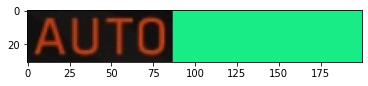

In [7]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)


Now we can run training.

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=10,
)

Epoch 1/10
  1/356 [..............................] - ETA: 44s - loss: 0.8697

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


356/356 [==============================] - 34s 94ms/step - loss: 0.5257 - val_loss: 1.8247
Epoch 2/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


356/356 [==============================] - 33s 93ms/step - loss: 0.5248 - val_loss: 1.8738
Epoch 3/10
356/356 [==============================] - 33s 94ms/step - loss: 0.4346 - val_loss: 1.9983
Epoch 4/10
356/356 [==============================] - 32s 91ms/step - loss: 0.4259 - val_loss: 1.5880
Epoch 5/10
356/356 [==============================] - 33s 93ms/step - loss: 0.4925 - val_loss: 1.7391
Epoch 6/10
356/356 [==============================] - 33s 93ms/step - loss: 0.3717 - val_loss: 1.9106
Epoch 7/10
356/356 [==============================] - 32s 91ms/step - loss: 0.3953 - val_loss: 1.7685
Epoch 8/10
356/356 [==============================] - 33s 93ms/step - loss: 0.3842 - val_loss: 1.9670
Epoch 9/10
356/356 [==============================] - 32s 91ms/step - loss: 0.3204 - val_loss: 2.2545
Epoch 10/10
356/356 [==============================] - 33s 93ms/step - loss: 0.3007 - val_loss: 2.4239


Finally, run inference on a test sample.

Predicted: today, Actual: today


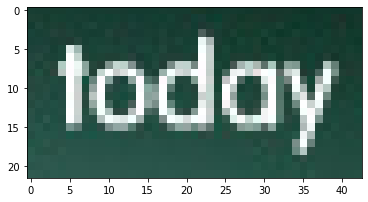

In [9]:
image_filepath, _, actual = test_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))